In [67]:
import pandas as pd
from amplpy import AMPL , add_to_path
import matplotlib.pyplot as plt

In [5]:
# Load cleaned adjusted close prices
df = pd.read_csv('../data/sp100_selected_data.csv', index_col=0, parse_dates=True)

# Ensure all values are numeric
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(method='ffill').fillna(method='bfill')


/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_60423/3011863545.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/sp100_selected_data.csv', index_col=0, parse_dates=True)
/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_60423/3011863545.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [6]:
def strip_suffix(name):
    return name.split('.')[0].strip()

df.columns = [strip_suffix(col) for col in df.columns]
df = df.loc[:, ~df.columns.duplicated()]

In [7]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod()


In [8]:
# Define q = number of stocks to select
q = 10
# Step 1: Drop ^OEX before correlation to avoid selecting it
correlations = cumulative_returns.drop(columns='^OEX').corrwith(cumulative_returns['^OEX'])

# Step 2: Get top 10 real stocks
top_q_stocks = correlations.sort_values(ascending=False).head(q).index.tolist()

# Calculate target return based on these stocks only
target_value = daily_returns[top_q_stocks].mean().mean()

# Display selected stock tickers
top_q_stocks


['AAPL', 'JPM', 'NVDA', 'AMZN', 'GOOGL', 'PG', 'UNH', 'MSFT', 'JNJ', 'XOM']

In [9]:
# Filter the daily returns for selected stocks and benchmark
returns_for_ampl = daily_returns[top_q_stocks + ['^OEX']]

# Show the shape and head of the data
returns_for_ampl.shape, returns_for_ampl.head()


((252, 11),
                 AAPL       JPM      NVDA      AMZN     GOOGL        PG  \
 Ticker                                                                   
 Date        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2024-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2024-04-02 -0.012326 -0.008000 -0.020499 -0.009514  0.018648 -0.013228   
 2024-04-03 -0.001715  0.003276  0.000407  0.004635  0.000652  0.006202   
 2024-04-04  0.008887  0.006389  0.021721  0.022790 -0.000651 -0.023346   
 
                  UNH      MSFT       JNJ       XOM      ^OEX  
 Ticker                                                        
 Date        0.000000  0.000000  0.000000  0.000000  0.000000  
 2024-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  
 2024-04-02 -0.070520 -0.009058 -0.007291  0.012971 -0.010852  
 2024-04-03  0.005222 -0.000904  0.007792  0.013229  0.000236  
 2024-04-04 -0.002554  0.012532 -0.015717 -0.003599  0.009844  )

In [10]:
# Average daily return for each stock (can be scaled later)
avg_returns = returns_for_ampl.mean()

# Print average return of each selected stock and the benchmark
avg_returns

# Calculate an achievable target return: average of selected stocks (excluding OEX)
target = avg_returns[top_q_stocks].mean()
print(f"Recommended target_return for AMPL: {target:.6f}")



Recommended target_return for AMPL: 0.000491


In [11]:
print(f"target_return: {avg_returns['^OEX']:.6f}")

target_return: 0.000334


In [12]:
# Clean and deduplicate stock selection
def clean_name(name):
    return name.replace("^", "").replace(".", "").replace("-", "").replace(" ", "").upper()

# Use only real stocks, exclude ^OEX from correlation matrix
correlations = cumulative_returns.drop(columns='^OEX').corrwith(cumulative_returns['^OEX'])

top_q_stocks = correlations.sort_values(ascending=False).head(10).index.tolist()

# Remove duplicates and clean names
top_q_stocks = list(dict.fromkeys(top_q_stocks))
name_map = {stock: clean_name(stock) for stock in top_q_stocks}
top_q_stocks_clean = [name_map[stock] for stock in top_q_stocks]

# Calculate average returns for selected stocks
avg_returns_selected = daily_returns[top_q_stocks].mean()

# Clean return index
avg_returns_clean = avg_returns_selected.rename(index=name_map)

# Build .dat file content
stock_set = "set STOCKS := " + ' '.join(top_q_stocks_clean) + ";\n"

return_param = "param r :=\n"
for stock in top_q_stocks:
    clean = name_map[stock]
    return_param += f"    {clean} {avg_returns_selected[stock]:.6f}\n"
return_param += ";\n"

# Calculate target return as average of selected stocks
target_value = avg_returns_selected.mean()
target_line = f"param target_return := {target_value:.6f};\n"

# Save to file
ampl_dat = stock_set + "\n" + return_param + "\n" + target_line
with open('../optimization/index_data.dat', 'w') as f:
    f.write(ampl_dat)

print("✅ FINAL clean .dat file created with:\n")
print(ampl_dat)

✅ FINAL clean .dat file created with:

set STOCKS := AAPL JPM NVDA AMZN GOOGL PG UNH MSFT JNJ XOM;

param r :=
    AAPL 0.001104
    JPM 0.000910
    NVDA 0.001267
    AMZN 0.000351
    GOOGL 0.000279
    PG 0.000310
    UNH 0.000447
    MSFT -0.000372
    JNJ 0.000343
    XOM 0.000270
;

param target_return := 0.000491;



In [13]:
# Step 1: Add AMPL to system path (update path if needed)
add_to_path("/Applications/AMPL")

# Step 2: Create AMPL instance
ampl = AMPL()
ampl.reset()

# Step 3: Load model and data
ampl.read("../optimization/index_model.mod")
ampl.read_data("../optimization/index_data.dat") 

# Step 4: Set solver and solve
ampl.set_option("solver", "minos")
ampl.solve()

# Step 5: Output results
print("✅ Tracking error:", ampl.get_value("tracking_error"))

w = ampl.get_variable("w")
print("\n📊 Portfolio Weights:")
for key, var in w:
    print(f"{key:<6} = {var.value():.4f}")



MINOS 5.51: optimal solution found.
1 iterations, objective 3.75769018e-15
Nonlin evals: obj = 8, grad = 7.
✅ Tracking error: 3.757690180294384e-15

📊 Portfolio Weights:
AAPL   = 0.5847
AMZN   = 0.0000
GOOGL  = 0.0000
JNJ    = 0.0000
JPM    = 0.0000
MSFT   = 0.4153
NVDA   = 0.0000
PG     = 0.0000
UNH    = 0.0000
XOM    = 0.0000


✅ AMPL weights saved to: ../data/ampl_portfolio_weights.csv


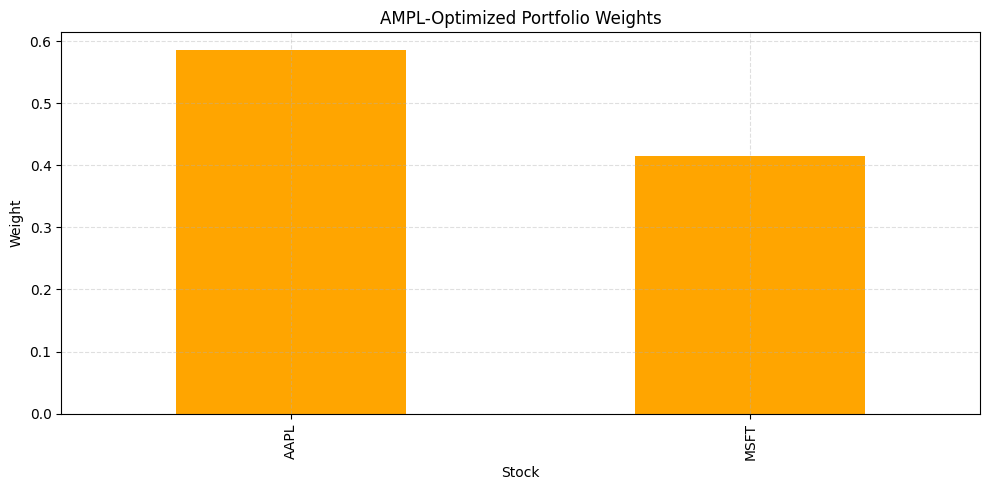

✅ AMPL weight chart saved to: ../data/ampl_portfolio_weights.png


In [16]:
# Get weights from AMPL solution
ampl_weights = {key: var.value() for key, var in w}
ampl_weights = pd.Series(ampl_weights)
ampl_weights = ampl_weights[ampl_weights > 0]  # Show only non-zero weights


# Save to CSV for evaluation
ampl_weights.to_csv("../data/ampl_portfolio_weights.csv", header=["Weight"])

print("✅ AMPL weights saved to: ../data/ampl_portfolio_weights.csv")

# Plot and save
plt.figure(figsize=(10, 5))
ampl_weights.plot(kind='bar', color='orange', title='AMPL-Optimized Portfolio Weights')
plt.ylabel("Weight")
plt.xlabel("Stock")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("✅ AMPL weight chart saved to: ../data/ampl_portfolio_weights.png")